# Requirements

## Data Format

Images are also provided in **`JPEG`** resized a uniform **`512x512`**.

Metadata is also provided outside of the DICOM format, in CSV files. See the Columns section for a description.

## What to predict. 
We have to predict a binary target for each image. The model model should predict the probability (floating point) between 0.0 and 1.0 that the lesion in the image is malignant (the target). In the training data, `train.csv`, the **value 0 denotes benign, and 1 indicates malignant.**

## Data Set Files
The dataset consists of images in :
* JPEG format in JPEG directory

Additionally, there is a metadata comprising of train, test and submission file in CSV format.
So the whole dataset looks like the following
* **train_color(dir)**
    * train_color --> all the jpg images in training  set
* **test_color(dir)**
    * test_color --> all the jpg images in testset    
* **train.csv** --> the training set metadata
* **test.csv**  -->the test set metadata
* sample_submission.csv --> a sample submission file in the correct format


# 1. Loading Libraries

In [5]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np 
import os
from pathlib import Path
import itertools
import random
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from tqdm import tqdm

import seaborn as sns

from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go

import tensorflow as tf
from keras.optimizers import Adam, RMSprop
from datetime import datetime, date
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from keras.applications.vgg16 import VGG16

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, confusion_matrix

import missingno as msno #need to see

from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score

2023-04-28 19:03:17.417783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 19:04:04.175384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-28 19:04:04.175448: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-28 19:04:09.066620: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-28 19:06:10.675244: W tensorflow/stream_executor/platform/de

In [21]:
SEED = 1
EPOCHS = 100
BATCH_SIZE = 32
NUM_CLASSES = 2
VERBOSE_LEVEL = 1
SAVE_OUTPUT = True
IMG_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

CWD = os.getcwd()
warnings.filterwarnings('ignore')

In [7]:
BASE_PATH = './'
PATH_TO_IMAGES = './train_color/train_color/' 
IMAGE_TYPE = ".jpg"

In [8]:
""" Helper function to validate the image paths

    Parameters:
        file_path (string): Path to the image 

    Returns:
        The file path if the file exists, otherwise false if the file does not exist

"""
def check_image(file_path):
    img_file = Path(file_path)
    if img_file.is_file():
        return file_path
    return False

In [10]:
""" Helper function to get the train dataset
"""
def get_train_data():
    # read the data from the train.csv file
    train = pd.read_csv(os.path.join(BASE_PATH, 'train.csv'))
    # add the image_path to the train set
    train['image_path'] = train['image_name'].apply(lambda x: PATH_TO_IMAGES + x + IMAGE_TYPE)
    # check if the we have an image 
    train['image_path'] = train.apply(lambda row : check_image(row['image_path']), axis = 1)
    # if we do not have an image we will not include the data
    train = train[train['image_path'] != False]
    print("valid rows in train", train.shape[0])
    return train

In [11]:
train_df = get_train_data()

valid rows in train 33126


In [12]:
train_df.head()

image_name  patient_id     sex  age_approx anatom_site_general_challenge  \
0  ISIC_2637011  IP_7279968    male        45.0                     head/neck   
1  ISIC_0015719  IP_3075186  female        45.0               upper extremity   
2  ISIC_0052212  IP_2842074  female        50.0               lower extremity   
3  ISIC_0068279  IP_6890425  female        45.0                     head/neck   
4  ISIC_0074268  IP_8723313  female        55.0               upper extremity   

  diagnosis benign_malignant  target  tfrecord  width  height  \
0   unknown           benign       0         0   6000    4000   
1   unknown           benign       0         0   6000    4000   
2     nevus           benign       0         6   1872    1053   
3   unknown           benign       0         0   1872    1053   
4   unknown           benign       0        11   6000    4000   

                                   image_path  
0  ./train_color/train_color/ISIC_2637011.jpg  
1  ./train_color/train_color/ISIC_0015719.jpg  
2  ./train_color/train_color/ISIC_0052212.jpg  
3  ./train_color/train_color/ISIC_0068279.jpg  
4  ./train_color/train_color/ISIC_0074268.jpg

# 2. Metadata Description
### Columns of `train.csv`
* image_name - unique identifier, points to filename of related DICOM image
* patient_id - unique patient identifier
* sex - the sex of the patient (when unknown, will be blank)
* age_approx - approximate patient age at time of imaging
* anatom_site_general_challenge - location of imaged site
* diagnosis - detailed diagnosis information (train only)
* benign_malignant - indicator of malignancy of imaged lesion
* target - binarized version of the target variable


# 3. Exploratory Data Analysis

### No of samples taken from patients frequency
Observing the number of patients and no of total samples,I came to the follwoing insights. 

* All the patients gave at least 2 samples.
* Maximum no of sample taken from a single patient is 115.
* On an average each patient gave 16 samples
* Median of samples of image per patient is 12
* Mode of samples of image per patient is 3

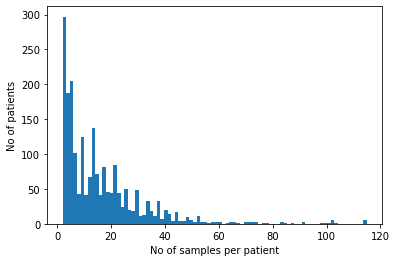

Minimum no of sample taken from  single patient 2
Maximum no of sample taken from  single patient 115
There are  16  samples taken from each patients on average
Median of no. of samples taken from  single patient 12
Mode of no. of samples taken from  single patient 3


In [8]:
image_freq_per_patient = train_df.groupby(['patient_id']).count()['image_name']
plt.hist(image_freq_per_patient.tolist(), bins = image_freq_per_patient.nunique())
plt.xlabel('No of samples per patient')
plt.ylabel('No of patients')
plt.show()
print('Minimum no of sample taken from  single patient', image_freq_per_patient.min())
print('Maximum no of sample taken from  single patient', image_freq_per_patient.max())
print('There are ',int( image_freq_per_patient.mean()), ' samples taken from each patients on average')
print('Median of no. of samples taken from  single patient', int(image_freq_per_patient.median()))
print('Mode of no. of samples taken from  single patient', int(image_freq_per_patient.mode()))

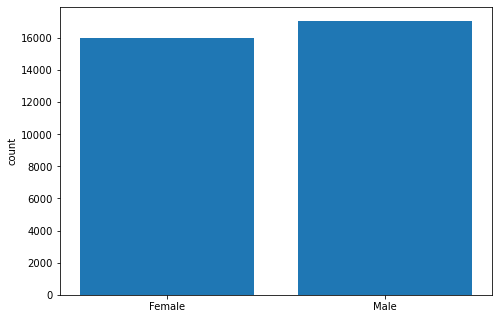

sex
female    15981
male      17080
Name: image_name, dtype: int64

In [9]:
sex_count = train_df.groupby(['sex']).count()['image_name']
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Female', 'Male'], sex_count)
plt.ylabel('count')
plt.show()
sex_count

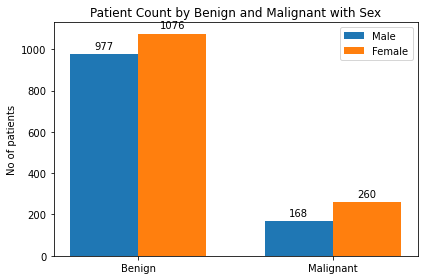

In [10]:
category_sex = train_df.groupby(['sex', 'benign_malignant']).nunique()['patient_id'].tolist()

labels = ['Benign', 'Malignant']
benign_data = category_sex[0:2]
maglignant_data = category_sex[2:4]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, benign_data, width, label='Male')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Female')
ax.set_ylabel('No of patients')
ax.set_title('Patient Count by Benign and Malignant with Sex')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

Here we observe that among the unique patients providing samples, 
* **Melanoma is more prevalant in Women** 
* **Among the Male patients, almost 24% are at malignant stage**
* **On the other hand, among Femele patients, about 17% are at malignant stage**

In [11]:
train_df.groupby(['benign_malignant', 'sex']).nunique()['patient_id']

benign_malignant  sex   
benign            female     977
                  male      1076
malignant         female     168
                  male       260
Name: patient_id, dtype: int64

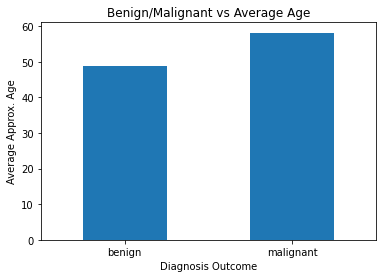

In [12]:
plt.figure()
train_df.groupby(['benign_malignant']).mean()['age_approx'].plot.bar(x = 'Diagnosis Type', y = 'Average age', rot = 0)
plt.title('Benign/Malignant vs Average Age')
plt.xlabel('Diagnosis Outcome')
plt.ylabel('Average Approx. Age')
plt.show()

Here we see that comparatively malignant patients are of higher age and their average age is almost 57 years whereas average age of the benign patients is close to 50. 

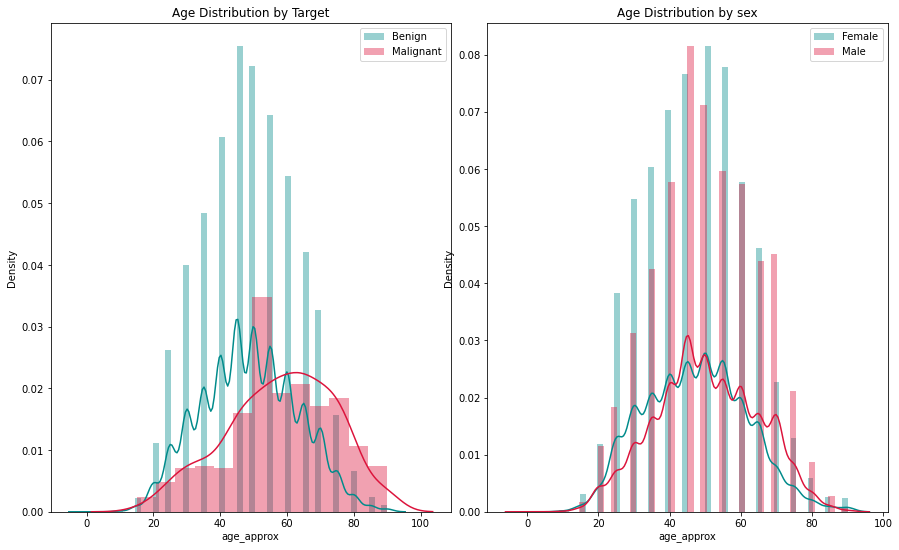

In [13]:
# Age distribution by target and sex
color1 = '#008B8B'
color2 = '#DC143C'
grid = GridSpec(nrows=1, ncols=4)
figure = plt.figure(figsize=(15, 9), constrained_layout=True)

ax1 = figure.add_subplot(grid[0, :2])
b, m = train_df.loc[train_df['target'] == 0,
                 'age_approx'], train_df.loc[train_df['target'] == 1, 'age_approx']
sns.distplot(b, ax=ax1, color=color1, label='Benign')
sns.distplot(m, ax=ax1, color=color2, label='Malignant')
ax1.set_title('Age Distribution by Target')
ax1.legend()

ax2 = figure.add_subplot(grid[0, 2:])
m, f = train_df.loc[train_df['sex'] == 'male', 'age_approx'], train_df.loc[train_df['sex'] == 'female',
                                                         'age_approx']
sns.distplot(f, ax=ax2, color=color1, label='Female')
sns.distplot(m, ax=ax2, color=color2, label='Male')
ax2.set_title('Age Distribution by sex')
ax2.legend()

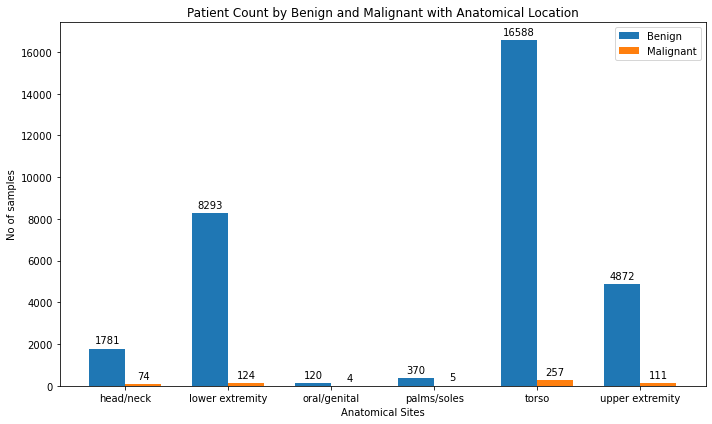

In [14]:
site_vs_diagnosis = train_df.groupby(['anatom_site_general_challenge', 'benign_malignant']).count()['patient_id'].tolist()
labels = ['head/neck', 'lower extremity', 'oral/genital','palms/soles', 'torso', 'upper extremity']
benign_data = site_vs_diagnosis[0:12:2]
maglignant_data = site_vs_diagnosis[1:12:2]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (10,6))
rects1 = ax.bar(x - width/2, benign_data, width, label='Benign')
rects2 = ax.bar(x + width/2, maglignant_data, width, label='Malignant')
ax.set_ylabel('No of samples')
ax.set_xlabel('Anatomical Sites')
ax.set_title('Patient Count by Benign and Malignant with Anatomical Location')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

**So the above graph says that oral/genital and palms/soles are least likely to develop Melanoma disease whereas most of the time torso develops melanoma**


In [15]:
# Donut Chart of Target
fig = go.Figure()
fig.add_trace(
    go.Pie(labels=train_df['benign_malignant'].value_counts().index,
           values=train_df['benign_malignant'].value_counts().values,
           hole=0.4,
           marker_colors=['#008B8B', '#FF7F50']))
fig.update_layout(title_text='Donut Chart of Target',
                  title_font_size=30,
                  annotations=[
                      dict(x=0.49,
                           y=0.5,
                           text='Target',
                           font_size=20,
                           showarrow=False)
                  ])
fig.show()

### Visualizing Benign and Malignant Images

Benign Images


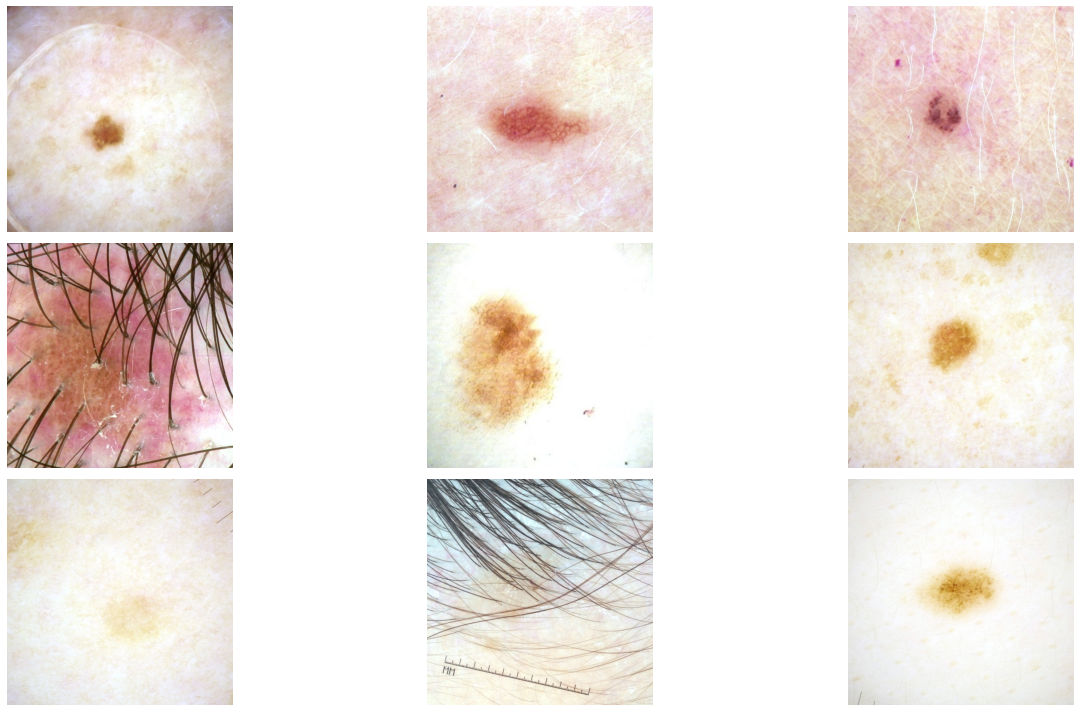

In [16]:
df = train_df
benign_images=df.loc[df.target==0,'image_name']
malignant_images=df.loc[df.target==1,'image_name']
random_benign_images=[np.random.choice(benign_images)+'.jpg' for i in range(9)]
random_malignant_images=[np.random.choice(malignant_images)+'.jpg' for i in range(9)]
figure=plt.figure(figsize=(20,10),tight_layout=True)
folder_path='./train_color/train_color/'
print('Benign Images')
for i in range(9):
    figure.add_subplot(3,3,i+1)
    image=plt.imread(os.path.join(folder_path,random_benign_images[i]))
    plt.imshow(image)
    plt.axis('off')
plt.show()

Malignant Images


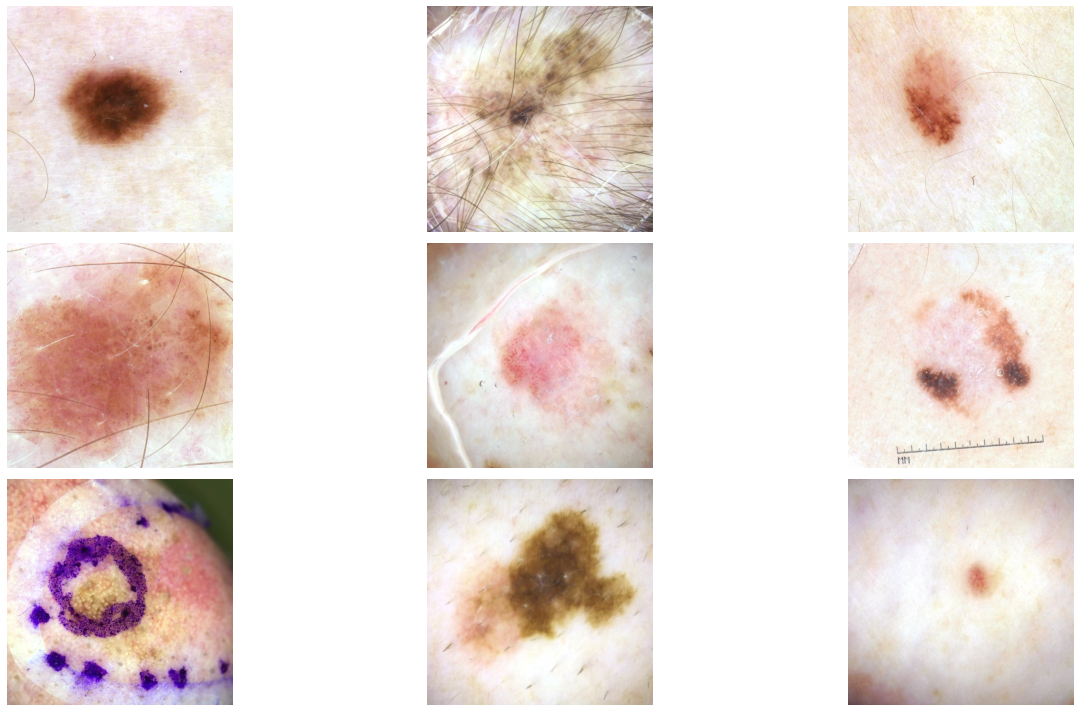

In [17]:
figure=plt.figure(figsize=(20,10),tight_layout=True)
print('Malignant Images')
for i in range(9):
    figure.add_subplot(3,3,i+1)
    image=plt.imread(os.path.join(folder_path,random_malignant_images[i]))
    plt.imshow(image)
    plt.axis('off')
plt.show()

Image dimensions:  (512, 512)
Maximum pixel value : 255.0 ; Minimum pixel value:33.0
Mean value of the pixels : 204.9 ; Standard deviation : 30.4


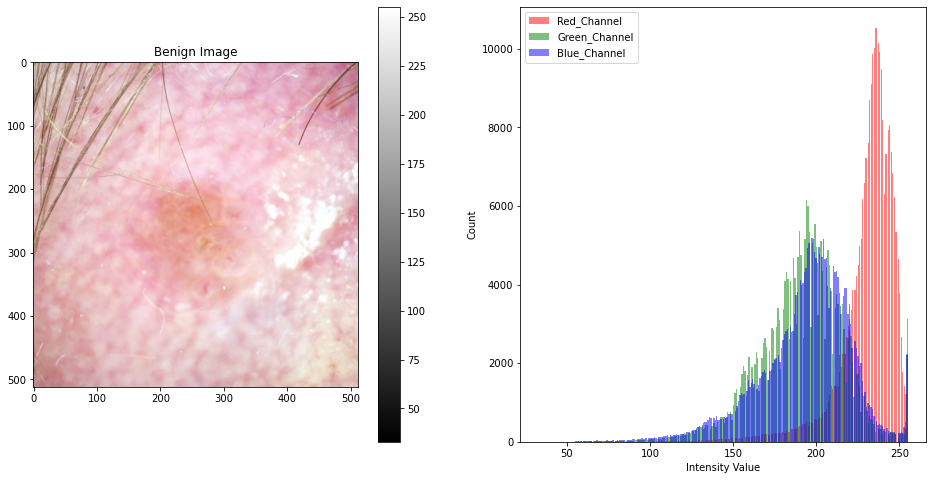

In [18]:
fig = plt.figure(figsize=(16,8))
fig.add_subplot(1,2, 1)
benign=train_df.loc[train_df.target==0]
sample_img = benign['image_name'][0]+'.jpg'
folder_path ='./train_color/train_color/'

raw_image = plt.imread(os.path.join(folder_path, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Benign Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

fig.add_subplot(1,2, 2)
# _ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange')
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

Image dimensions:  (512, 512)
Maximum pixel value : 255.0 ; Minimum pixel value:60.0
Mean value of the pixels : 225.2 ; Standard deviation : 24.3


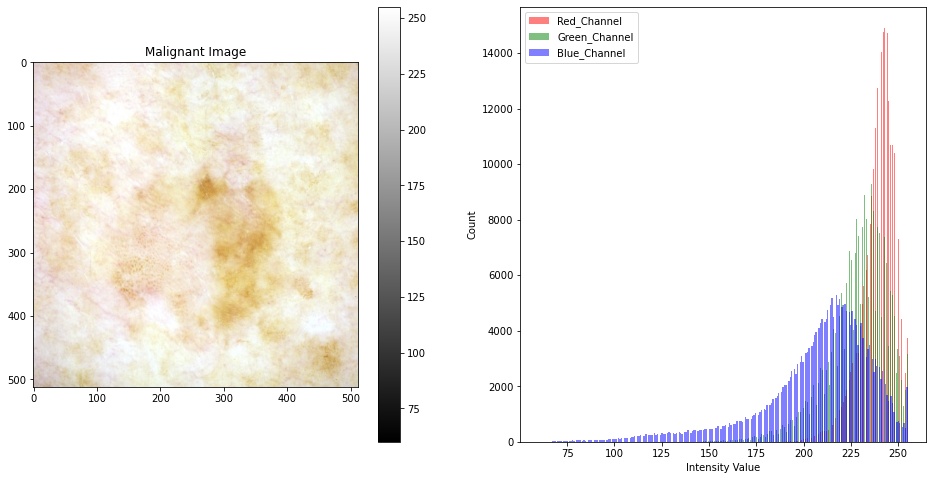

In [19]:
f = plt.figure(figsize=(16,8))
f.add_subplot(1,2, 1)
malignant=train_df.loc[train_df.target==1].reset_index(drop=True)
sample_img = malignant['image_name'][0]+'.jpg'
raw_image = plt.imread(os.path.join(folder_path, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Malignant Image')
print(f"Image dimensions:  {raw_image.shape[0],raw_image.shape[1]}")
print(f"Maximum pixel value : {raw_image.max():.1f} ; Minimum pixel value:{raw_image.min():.1f}")
print(f"Mean value of the pixels : {raw_image.mean():.1f} ; Standard deviation : {raw_image.std():.1f}")

f.add_subplot(1,2, 2)

#_ = plt.hist(raw_image.ravel(),bins = 256, color = 'orange',)
_ = plt.hist(raw_image[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 1].ravel(), bins = 256, color = 'Green', alpha = 0.5)
_ = plt.hist(raw_image[:, :, 2].ravel(), bins = 256, color = 'Blue', alpha = 0.5)
_ = plt.xlabel('Intensity Value')
_ = plt.ylabel('Count')
_ = plt.legend(['Red_Channel', 'Green_Channel', 'Blue_Channel'])
plt.show()

# 4.  Data Preprocessing

### Check for missing values

In [13]:
""" Helper function check a dataframe for missing values
    Parameters:

        df (dataframe): The dataframe to check
    Returns:
        A dataframe with the number of missing and zero values for each column in percent
"""
def check_for_missing_and_null(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                            'percent_zero': df.isin([0]).sum() * 100 / len(df),
                            'total_zero': df.isnull().sum() * 100 / len(df) + df.isin([0]).sum() * 100 / len(df),
                           })
    return null_df

check_for_missing_and_null(train_df)

columns  percent_null  \
image_name                                        image_name      0.000000   
patient_id                                        patient_id      0.000000   
sex                                                      sex      0.196220   
age_approx                                        age_approx      0.205277   
anatom_site_general_challenge  anatom_site_general_challenge      1.590895   
diagnosis                                          diagnosis      0.000000   
benign_malignant                            benign_malignant      0.000000   
target                                                target      0.000000   
tfrecord                                            tfrecord      0.000000   
width                                                  width      0.000000   
height                                                height      0.000000   
image_path                                        image_path      0.000000   

                               percent_zero  total_zero  
image_name                         0.000000    0.000000  
patient_id                         0.000000    0.000000  
sex                                0.000000    0.196220  
age_approx                         0.006038    0.211314  
anatom_site_general_challenge      0.000000    1.590895  
diagnosis                          0.000000    0.000000  
benign_malignant                   0.000000    0.000000  
target                            98.237034   98.237034  
tfrecord                           6.586971    6.586971  
width                              0.000000    0.000000  
height                             0.000000    0.000000  
image_path                         0.000000    0.000000

There is a small portion of missing values for age and sex, as well as for the anatom_site_general_challenge column. 

The target column consists of 98 % zero values. This means we have a highly imbalanced dataset.

### Removing missing values

To do the EDA, I will remove the dataset's missing values because we will not lose much information. Later, when we prepare the dataset for training, I will add these missing values again.

In [14]:
train = train_df.dropna()

In [15]:
# getting dummy variables for gender
sex_dummies = pd.get_dummies(train['sex'], prefix='sex', dtype="int")
train = pd.concat([train, sex_dummies], axis=1)

# getting dummy variables for anatom_site_general_challenge
anatom_dummies = pd.get_dummies(train['anatom_site_general_challenge'], prefix='anatom', dtype="int")
train = pd.concat([train, anatom_dummies], axis=1)

# getting dummy variables for target column
#target_dummies = pd.get_dummies(train['target'], prefix='target', dtype="int")
#train = pd.concat([train, target_dummies], axis=1)

# dropping not useful columns
train.drop(['sex','diagnosis','benign_malignant','anatom_site_general_challenge'], axis=1, inplace=True)

# replace missing age values wiht the mean age
train['age_approx'] = train['age_approx'].fillna(int(np.mean(train['age_approx'])))

# convert age to int
train['age_approx'] = train['age_approx'].astype('int')

print("rows in train", train.shape[0])

rows in train 32531


In [16]:
# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20%; 8 = ~11%; 12 = ~8%
balance = 1
p_inds = train[train.target == 1].index.tolist()
np_inds = train[train.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train = train.loc[p_inds + np_sample]
df = train
print("Samples in train", train['target'].sum()/len(train))
print("Remaining rows in train set", len(train))

Samples in train 0.5
Remaining rows in train set 1150


In [17]:
""" Helper function to create a train and a validation dataset

    Parameters:
    df (dataframe): The dataframe to split
    test_size (int): Size of the validation set
    classToPredict: The target column

    Returns:
    train_data (dataframe)
    val_data (dataframe)
"""
def create_splits(df, test_size, classToPredict):
    train_data, val_data = train_test_split(df,  test_size = test_size, random_state = 1, stratify = df[classToPredict])
    train_data, test_data = train_test_split(df,  test_size = 0.16, random_state = 1, stratify = df[classToPredict])
    return train_data, val_data, test_data

In [18]:
""" Helper function to plot the history of a tensorflow model

    Parameters:
        history (history object): The history from a tf model
        timestamp (string): The timestamp of the function execution

    Returns:
        Null
"""
def save_history(history, timestamp):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history['val_loss'], label='val loss')
    plt.plot(history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")

    f.add_subplot(1, 2, 2)
    plt.plot(history['val_accuracy'], label='val accuracy')
    plt.plot(history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

In [26]:
""" Helper function to plot the auc curve

    Parameters:
        t_y (array): True binary labels
        p_y (array): Target scores

    Returns:
        Null
"""
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (8, 8))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Target', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

In [27]:
""" Factory function to create a training image data generator

Parameters:
    df (dataframe): Training dataframe 

Returns:
    Image Data Generator function
"""
def get_training_gen(df):
    ## prepare images for training
    train_idg = ImageDataGenerator(
        rescale = 1 / 255.0,
        horizontal_flip = True, 
        vertical_flip = True, 
        height_shift_range = 0.15, 
        width_shift_range = 0.15,
        shear_range=0.15,
        rotation_range = 90, 
        zoom_range = 0.20,
        fill_mode='nearest'
    )

    train_gen = train_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col='target',
        class_mode='raw',
        shuffle=True,
        target_size=IMG_SIZE,
        #batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return train_gen

In [28]:
""" Factory function to create a validation image data generator

Parameters:
    df (dataframe): Validation dataframe 

Returns:
    Image Data Generator function
"""
def get_validation_gen(df):
    ## prepare images for validation
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col='target',
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        #batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return val_gen

In [29]:
""" Factory function to create a test image data generator

Parameters:
    df (dataframe): Test dataframe 

Returns:
    Image Data Generator function
"""
def get_test_gen(df):
    ## prepare images for validation
    test_idg = ImageDataGenerator(rescale=1. / 255.0)
    test_gen = test_idg.flow_from_dataframe(
        seed=SEED,
        dataframe=df,
        directory=None,
        x_col='image_path',
        y_col='target',
        class_mode='raw',
        shuffle=False,
        target_size=IMG_SIZE,
        #batch_size=BATCH_SIZE,
        validate_filenames = False
    )

    return test_gen

# Training Through Images

In [30]:
train_gen = get_training_gen(train)

Found 1150 non-validated image filenames.


The Image Data Generator function returns these transformed images.

The Keras ImageDataGenerator class works by:
- Accepting a batch of images used for training.
- Taking this batch and applying a series of random transformations to each image in the batch (including random rotation, resizing, shearing, etc.).
- Replacing and returning the original batch with the new, randomly transformed batch.

We will use a pretrained model to extract features in the images and then use classical models and deep learning models to predict on it. It is going to extract the features of images and then use those features to predict the image.

In [22]:
""" Helper function which returns a VGG16 model
"""
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np

def load_pretrained_model():
    base_model = VGG16(
        input_shape=INPUT_SHAPE,
        include_top=False,
        weights='imagenet'
    )

    return base_model

In [23]:
model = load_pretrained_model()
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [24]:
last_layer_shape = model.layers[-1].output_shape
import keras.utils as image
from keras.applications.vgg16 import preprocess_input
last_layer_shape

(None, 7, 7, 512)

In [25]:
import keras.utils as image
from keras.applications.vgg16 import preprocess_input

def extract_features(df, use_model_features=True):
    features = []
    labels = []
    for img_path in df['image_path']:
        img = image.load_img(img_path, target_size=INPUT_SHAPE)
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)

        if use_model_features:
            img_data = preprocess_input(img_data)
            feature = model.predict(img_data)
            feature_np = np.array(feature)
            features.append(feature_np.flatten())
        else:
            features.append(img_data.flatten())

        labels.append(df.loc[df['image_path'] == img_path, 'target'].iloc[0])
        
    feature_list_np = np.array(features)
    feature_list_np = tf.keras.preprocessing.sequence.pad_sequences(
      feature_list_np,
      maxlen = 25088,
      dtype = "int32",
      padding = "pre",
      truncating = "pre",
      value = 0
    )
    labels_list_np = np.array(labels)
    
    return feature_list_np, labels_list_np

In [26]:
# create a training and validation dataset from the train df
train_df, val_df, test_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])
print("rows in test_df", test_df.shape[0])

rows in train_df 966
rows in val_df 230
rows in test_df 184


In [30]:
train_len = train_df.shape[0]
val_len = val_df.shape[0]
test_len = test_df.shape[0]

In [31]:
train_features, train_labels = extract_features(train_df,use_model_features=False)
val_features, val_labels = extract_features(val_df,use_model_features=False)
test_features, test_labels = extract_features(test_df,use_model_features=False)

In [32]:
X_train, y_train = train_features, train_labels
X_val, y_val = val_features, val_labels
X_test, y_test = test_features, test_labels

## KMeans

In [37]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train)

KMeans(n_clusters=2, random_state=0)

In [40]:
from sklearn.metrics import silhouette_score
silhouette = silhouette_score(X_train, kmeans.labels_)
print("Silhouette score:", silhouette)

Silhouette score: 0.5170565367581895


## SVM

In [39]:
from sklearn.svm import SVC

# Create the SVM classifier with rbf kernel and set n_jobs to use all available cores
classifier_SVM = SVC(kernel='rbf', random_state=0)

# Fit the classifier to the training data
classifier_SVM.fit(X_train, y_train)

SVC(random_state=0)

In [40]:
train_acc_SVM = classifier_SVM.score(X_train, y_train)
val_acc_SVM = classifier_SVM.score(X_val, y_val)
test_acc_SVM = classifier_SVM.score(X_test, y_test)

In [41]:
print(train_acc_SVM)
print(val_acc_SVM)
print(test_acc_SVM)

0.7815734989648033
0.6956521739130435
0.6521739130434783


In [42]:
y_pred_SVM = classifier_SVM.predict(X_test)

In [43]:
from sklearn import metrics
def print_performance_metrics(test_labels,predict):
    print('Accuracy:', np.round(metrics.accuracy_score(test_labels, predict),4))
    print('ROC Area:', np.round(metrics.roc_auc_score(test_labels, predict),4))
    print('Precision:', np.round(metrics.precision_score(test_labels, predict,average='weighted'),4))
    print('Recall:', np.round(metrics.recall_score(test_labels, predict,
                                               average='weighted'),4))
    print('F1 Score:', np.round(metrics.f1_score(test_labels, predict,
                                               average='weighted'),4))
    print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(test_labels, predict),4))
    print('Matthews Corrcoef:', np.round(metrics.matthews_corrcoef(test_labels, predict),4)) 
    print('\t\tClassification Report:\n', metrics.classification_report(test_labels, predict))

In [44]:
print_performance_metrics(y_test,y_pred_SVM)

Accuracy: 0.6522
ROC Area: 0.6522
Precision: 0.6614
Recall: 0.6522
F1 Score: 0.6471
Cohen Kappa Score: 0.3043
Matthews Corrcoef: 0.3134
		Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.53      0.60        92
           1       0.62      0.77      0.69        92

    accuracy                           0.65       184
   macro avg       0.66      0.65      0.65       184
weighted avg       0.66      0.65      0.65       184



In [45]:
# create a confusion matrix
cm_SVM =  confusion_matrix(y_test,y_pred_SVM)
cm_SVM

array([[49, 43],
       [21, 71]])

In [46]:
""" Helper function to plot a confusion matrix

    Parameters:
        cm (confusion matrix)

    Returns:
        Null
"""
def plot_confusion_matrix(cm, labels):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=55)
    plt.yticks(tick_marks, labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [47]:
cm_plot_label =['benign', 'malignant']

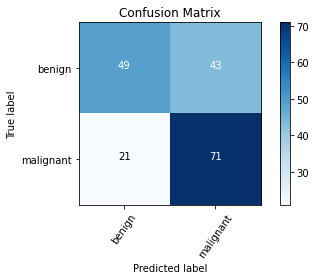

In [48]:
plot_confusion_matrix(cm_SVM, cm_plot_label)

##  RANDOM FOREST

In [49]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators = 800, criterion = 'entropy', random_state = 0)
classifier_RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=800, random_state=0)

In [50]:
train_acc_RF = classifier_RF.score(X_train, y_train)
val_acc_RF = classifier_RF.score(X_val, y_val)
test_acc_RF = classifier_RF.score(X_test, y_test)

In [51]:
print(train_acc_RF)
print(val_acc_RF)
print(test_acc_RF)

1.0
0.7782608695652173
0.7228260869565217


In [52]:
y_pred_RF = classifier_RF.predict(X_test)

In [53]:
print_performance_metrics(y_test,y_pred_RF)

Accuracy: 0.7228
ROC Area: 0.7228
Precision: 0.7328
Recall: 0.7228
F1 Score: 0.7198
Cohen Kappa Score: 0.4457
Matthews Corrcoef: 0.4555
		Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.62      0.69        92
           1       0.68      0.83      0.75        92

    accuracy                           0.72       184
   macro avg       0.73      0.72      0.72       184
weighted avg       0.73      0.72      0.72       184



In [54]:
# create a confusion matrix
cm_RF =  confusion_matrix(y_test,y_pred_RF)
cm_RF

array([[57, 35],
       [16, 76]])

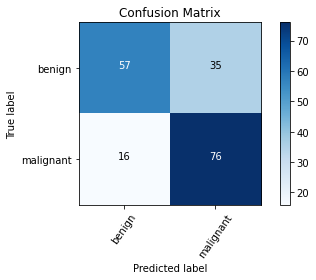

In [55]:
plot_confusion_matrix(cm_RF, cm_plot_label)

## KNN

In [4]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kNN = KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30)
classifier_kNN.fit(X_train, y_train)

NameError: name 'X_train' is not defined

In [57]:
train_acc_kNN = classifier_kNN.score(X_train, y_train)
val_acc_kNN = classifier_kNN.score(X_val, y_val)
test_acc_kNN = classifier_kNN.score(X_test, y_test)

In [58]:
print(train_acc_kNN)
print(val_acc_kNN)
print(test_acc_kNN)

0.7795031055900621
0.6652173913043479
0.6086956521739131


In [59]:
y_pred_kNN = classifier_kNN.predict(X_test)

In [60]:
print_performance_metrics(y_test,y_pred_kNN)

Accuracy: 0.6087
ROC Area: 0.6087
Precision: 0.6092
Recall: 0.6087
F1 Score: 0.6083
Cohen Kappa Score: 0.2174
Matthews Corrcoef: 0.2179
		Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.64      0.62        92
           1       0.62      0.58      0.60        92

    accuracy                           0.61       184
   macro avg       0.61      0.61      0.61       184
weighted avg       0.61      0.61      0.61       184



In [61]:
# create a confusion matrix
cm_kNN =  confusion_matrix(y_test,y_pred_kNN)
cm_kNN

array([[59, 33],
       [39, 53]])

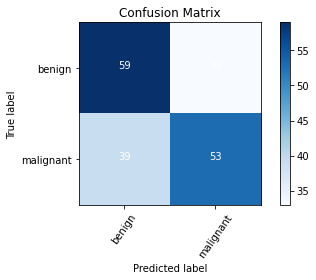

In [62]:
plot_confusion_matrix(cm_kNN, cm_plot_label)

## Logistic Regression

In [63]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(random_state=0)
classifier_LR.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [64]:
train_acc_LR = classifier_LR.score(X_train, y_train)
val_acc_LR = classifier_LR.score(X_val, y_val)
test_acc_LR = classifier_LR.score(X_test, y_test)

In [65]:
print(train_acc_LR)
print(val_acc_LR)
print(test_acc_LR)

0.8581780538302277
0.6695652173913044
0.6304347826086957


In [66]:
y_pred_LR = classifier_LR.predict(X_test)

In [67]:
print_performance_metrics(y_test,y_pred_LR)

Accuracy: 0.6304
ROC Area: 0.6304
Precision: 0.6305
Recall: 0.6304
F1 Score: 0.6304
Cohen Kappa Score: 0.2609
Matthews Corrcoef: 0.2609
		Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.62      0.63        92
           1       0.63      0.64      0.63        92

    accuracy                           0.63       184
   macro avg       0.63      0.63      0.63       184
weighted avg       0.63      0.63      0.63       184



In [68]:
# create a confusion matrix
cm_LR =  confusion_matrix(y_test,y_pred_LR)
cm_LR

array([[57, 35],
       [33, 59]])

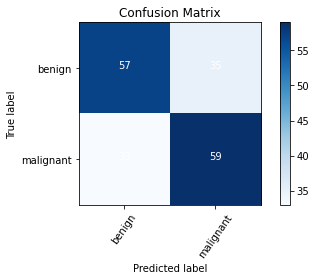

In [69]:
plot_confusion_matrix(cm_LR, cm_plot_label)

## Xgboost (Decision Trees)

In [70]:
import xgboost as xgb
classifier_xgb = xgb.XGBClassifier(n_estimators = 300)
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [71]:
train_acc_xgb = classifier_xgb.score(X_train, y_train)
val_acc_xgb = classifier_xgb.score(X_val, y_val)
test_acc_xgb = classifier_xgb.score(X_test, y_test)

In [72]:
print(train_acc_xgb)
print(val_acc_xgb)
print(test_acc_xgb)

1.0
0.7260869565217392
0.657608695652174


In [73]:
y_pred_xgb = classifier_xgb.predict(X_test)

In [74]:
print_performance_metrics(y_test,y_pred_xgb)

Accuracy: 0.6576
ROC Area: 0.6576
Precision: 0.6619
Recall: 0.6576
F1 Score: 0.6553
Cohen Kappa Score: 0.3152
Matthews Corrcoef: 0.3195
		Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.58      0.63        92
           1       0.64      0.74      0.68        92

    accuracy                           0.66       184
   macro avg       0.66      0.66      0.66       184
weighted avg       0.66      0.66      0.66       184



In [75]:
# create a confusion matrix
cm_xgb =  confusion_matrix(y_test,y_pred_xgb)
cm_xgb

array([[53, 39],
       [24, 68]])

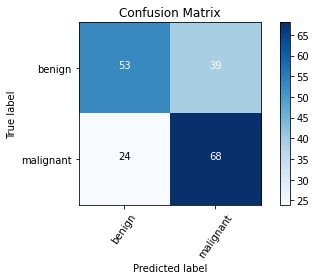

In [76]:
plot_confusion_matrix(cm_xgb, cm_plot_label)

## CNN

In [95]:
model_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(7, 7, 512)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 1)), # reduce only depth dimension
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


LEARNING_RATE = 1e-4
OPTIMIZER = RMSprop(lr=LEARNING_RATE,decay=1e-2)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model_CNN.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

print("fit model on gpu")
history_CNN = model_CNN.fit(
    np.reshape(train_features,(train_features.shape[0],7,7,512)), train_labels, 
    epochs=EPOCHS, 
    verbose=VERBOSE_LEVEL, 
    validation_data=( np.reshape(val_features,(val_features.shape[0],7,7,512)),val_labels)
)

fit model on gpu
Epoch 1/100
31/31 [==============================] - 1s 22ms/step - loss: 3.9890 - accuracy: 0.5052 - auc: 0.4949 - val_loss: 5.2499 - val_accuracy: 0.5000 - val_auc: 0.5261
Epoch 2/100
31/31 [==============================] - 1s 18ms/step - loss: 1.7050 - accuracy: 0.4876 - auc: 0.5095 - val_loss: 3.9352 - val_accuracy: 0.5000 - val_auc: 0.5223
Epoch 3/100
31/31 [==============================] - 1s 18ms/step - loss: 1.0102 - accuracy: 0.5528 - auc: 0.5700 - val_loss: 1.2759 - val_accuracy: 0.5130 - val_auc: 0.6968
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 0.8378 - accuracy: 0.5435 - auc: 0.5793 - val_loss: 0.8364 - val_accuracy: 0.5696 - val_auc: 0.6017
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 0.8364 - accuracy: 0.5725 - auc: 0.5944 - val_loss: 0.7378 - val_accuracy: 0.5261 - val_auc: 0.6185
Epoch 6/100
31/31 [==============================] - 1s 16ms/step - loss: 0.7243 - accuracy: 0.6056 - auc: 0.6286

Epoch 48/100
31/31 [==============================] - 1s 19ms/step - loss: 0.5000 - accuracy: 0.7360 - auc: 0.8343 - val_loss: 0.6592 - val_accuracy: 0.6652 - val_auc: 0.7431
Epoch 49/100
31/31 [==============================] - 1s 18ms/step - loss: 0.5005 - accuracy: 0.7453 - auc: 0.8326 - val_loss: 0.6090 - val_accuracy: 0.7000 - val_auc: 0.7663
Epoch 50/100
31/31 [==============================] - 1s 20ms/step - loss: 0.4985 - accuracy: 0.7547 - auc: 0.8353 - val_loss: 0.6122 - val_accuracy: 0.7348 - val_auc: 0.7612
Epoch 51/100
31/31 [==============================] - 1s 19ms/step - loss: 0.4973 - accuracy: 0.7516 - auc: 0.8370 - val_loss: 0.6274 - val_accuracy: 0.7087 - val_auc: 0.7591
Epoch 52/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4957 - accuracy: 0.7422 - auc: 0.8352 - val_loss: 0.6230 - val_accuracy: 0.6739 - val_auc: 0.7541
Epoch 53/100
31/31 [==============================] - 1s 20ms/step - loss: 0.4892 - accuracy: 0.7536 - auc: 0.8434 - val_loss

Epoch 95/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4515 - accuracy: 0.7909 - auc: 0.8715 - val_loss: 0.6117 - val_accuracy: 0.7130 - val_auc: 0.7767
Epoch 96/100
31/31 [==============================] - 1s 21ms/step - loss: 0.4516 - accuracy: 0.7836 - auc: 0.8709 - val_loss: 0.6204 - val_accuracy: 0.7043 - val_auc: 0.7694
Epoch 97/100
31/31 [==============================] - 1s 19ms/step - loss: 0.4504 - accuracy: 0.7785 - auc: 0.8714 - val_loss: 0.6117 - val_accuracy: 0.7261 - val_auc: 0.7745
Epoch 98/100
31/31 [==============================] - 1s 18ms/step - loss: 0.4496 - accuracy: 0.7867 - auc: 0.8734 - val_loss: 0.6082 - val_accuracy: 0.7304 - val_auc: 0.7765
Epoch 99/100
31/31 [==============================] - 1s 20ms/step - loss: 0.4499 - accuracy: 0.7836 - auc: 0.8740 - val_loss: 0.6159 - val_accuracy: 0.7130 - val_auc: 0.7763
Epoch 100/100
31/31 [==============================] - 1s 20ms/step - loss: 0.4492 - accuracy: 0.7888 - auc: 0.8738 - val_los

Binary cross-entropy is a suitable loss function for your problem for several reasons:

1. **Binary problem:** Since your goal is to predict whether an image is benign or malignant, you have a binary classification task. Binary cross-entropy is specifically designed for problems with two classes, making it an appropriate choice for your problem.

2. **Probabilistic interpretation:** Binary cross-entropy loss measures the difference between the predicted probabilities and the true binary labels, which is suitable for this problem because the output of a CNN for binary classification is typically a sigmoid activation function that returns a probability between 0 and 1. This probability represents the likelihood that an image is malignant.

3. **Penalizes incorrect predictions:** Binary cross-entropy loss heavily penalizes predictions that are far from the true label. This property encourages the model to output probabilities close to the true label, improving classification performance.

4. **Gradient-based optimization:** CNNs are typically optimized using gradient-based techniques like stochastic gradient descent (SGD) or its variants. Binary cross-entropy is a smooth, differentiable function that provides informative gradients to update the model's parameters, facilitating the optimization process.

5. **Robustness:** Binary cross-entropy is less sensitive to imbalanced datasets, which can occur in medical imaging tasks like predicting malignancy. This robustness is helpful because it reduces the chance of the model being biased towards the majority class.

In summary, binary cross-entropy is a good choice for your problem because it's designed for binary classification tasks, provides a probabilistic interpretation, penalizes incorrect predictions, works well with gradient-based optimization, and is robust to class imbalance. This makes it a suitable loss function for training a CNN to predict whether an image is benign or malignant. remove extra info and improve readibilty Change this in markdown format

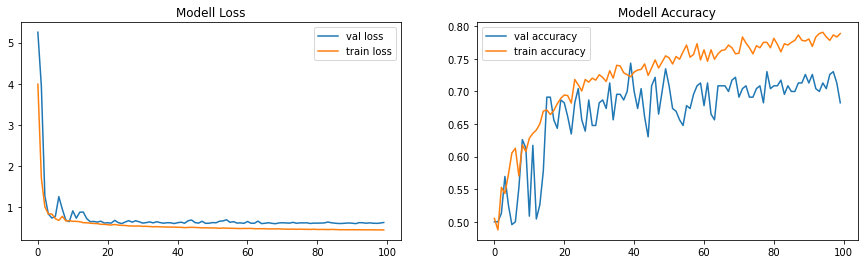

In [97]:
# get the current timestamp. This timestamp is used to save the model data with a unique name
now = datetime.now()
today = date.today()
current_time = now.strftime("%H:%M:%S")

# plot model history
save_history(history_CNN.history, current_time)

In [99]:
y_pred_CNN = model_CNN.predict(np.reshape(X_test, (X_test.shape[0], 7, 7, 512)))

6/6 [==============================] - 0s 3ms/step


In [104]:
""" Helper function turn the model predictions into a binary (0,1) format

    Parameters:
        pred (float): Model prediction

    Returns:
        binary prediction (int)
"""

def pred_to_binary(pred):
    if pred < 0.5:
        return 0
    else:
        return 1

y_pred_CNN = [pred_to_binary(x) for x in y_pred_CNN]

In [105]:
print_performance_metrics(y_test,y_pred_CNN)

Accuracy: 0.6359
ROC Area: 0.6359
Precision: 0.6407
Recall: 0.6359
F1 Score: 0.6327
Cohen Kappa Score: 0.2717
Matthews Corrcoef: 0.2765
		Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.54      0.60        92
           1       0.61      0.73      0.67        92

    accuracy                           0.64       184
   macro avg       0.64      0.64      0.63       184
weighted avg       0.64      0.64      0.63       184



In [106]:
# create a confusion matrix
cm_CNN =  confusion_matrix(y_test,y_pred_CNN)
cm_CNN

array([[50, 42],
       [25, 67]])

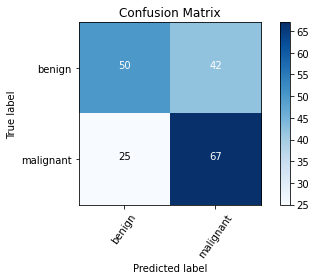

In [107]:
plot_confusion_matrix(cm_CNN, cm_plot_label)

## RNN

In [111]:
#For LSTMs

train_features_2d = np.zeros((train_len,last_layer_shape[1],last_layer_shape[2]*last_layer_shape[3]))
for i in range(len(train_labels)):
    train_features_2d[i] = train_features[i].reshape(last_layer_shape[1],
                                                     last_layer_shape[2]*last_layer_shape[3])
    
val_features_2d = np.zeros((val_len,last_layer_shape[1],last_layer_shape[2]*last_layer_shape[3]))
for i in range(len(val_labels)):
    val_features_2d[i] = val_features[i].reshape(last_layer_shape[1],
                                                     last_layer_shape[2]*last_layer_shape[3])
    
test_features_2d = np.zeros((test_len,last_layer_shape[1],last_layer_shape[2]*last_layer_shape[3]))
for i in range(len(test_labels)):
    test_features_2d[i] = test_features[i].reshape(last_layer_shape[1],
                                                     last_layer_shape[2]*last_layer_shape[3])

In [112]:
model_LSTM = tf.keras.models.Sequential([
    tf.keras.Input(shape=(last_layer_shape[1], last_layer_shape[2]*last_layer_shape[3])),
    tf.keras.layers.LSTM(100, return_sequences=True),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

LEARNING_RATE = 1e-4
OPTIMIZER = Adam(lr=LEARNING_RATE,decay=1e-2)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model_LSTM.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

print("fit model on gpu")
history_LSTM = model_LSTM.fit(
    train_features_2d, train_labels, 
    epochs=EPOCHS, 
    verbose=VERBOSE_LEVEL,
    validation_data=(val_features_2d,val_labels)
)

fit model on gpu
Epoch 1/100
31/31 [==============================] - 6s 48ms/step - loss: 0.7164 - accuracy: 0.4979 - auc: 0.5284 - val_loss: 0.6973 - val_accuracy: 0.5000 - val_auc: 0.5239
Epoch 2/100
31/31 [==============================] - 1s 28ms/step - loss: 0.6952 - accuracy: 0.5000 - auc: 0.5048 - val_loss: 0.6994 - val_accuracy: 0.5000 - val_auc: 0.5675
Epoch 3/100
31/31 [==============================] - 1s 28ms/step - loss: 0.6948 - accuracy: 0.5000 - auc: 0.5149 - val_loss: 0.6943 - val_accuracy: 0.5000 - val_auc: 0.5004
Epoch 4/100
31/31 [==============================] - 1s 28ms/step - loss: 0.6924 - accuracy: 0.5000 - auc: 0.5298 - val_loss: 0.6969 - val_accuracy: 0.5000 - val_auc: 0.5167
Epoch 5/100
31/31 [==============================] - 1s 28ms/step - loss: 0.6957 - accuracy: 0.5000 - auc: 0.5261 - val_loss: 0.6939 - val_accuracy: 0.5000 - val_auc: 0.6371
Epoch 6/100
31/31 [==============================] - 1s 29ms/step - loss: 0.6916 - accuracy: 0.5000 - auc: 0.5537

Epoch 48/100
31/31 [==============================] - 1s 33ms/step - loss: 0.6795 - accuracy: 0.6398 - auc: 0.7195 - val_loss: 0.6884 - val_accuracy: 0.5043 - val_auc: 0.6770
Epoch 49/100
31/31 [==============================] - 1s 31ms/step - loss: 0.6807 - accuracy: 0.6232 - auc: 0.6865 - val_loss: 0.6842 - val_accuracy: 0.6391 - val_auc: 0.6898
Epoch 50/100
31/31 [==============================] - 1s 30ms/step - loss: 0.6791 - accuracy: 0.6708 - auc: 0.7258 - val_loss: 0.6819 - val_accuracy: 0.6609 - val_auc: 0.7113
Epoch 51/100
31/31 [==============================] - 1s 32ms/step - loss: 0.6770 - accuracy: 0.6646 - auc: 0.7259 - val_loss: 0.6799 - val_accuracy: 0.6478 - val_auc: 0.7083
Epoch 52/100
31/31 [==============================] - 1s 32ms/step - loss: 0.6753 - accuracy: 0.6677 - auc: 0.7210 - val_loss: 0.6782 - val_accuracy: 0.6522 - val_auc: 0.7090
Epoch 53/100
31/31 [==============================] - 1s 35ms/step - loss: 0.6734 - accuracy: 0.6729 - auc: 0.7272 - val_loss

Epoch 95/100
31/31 [==============================] - 1s 34ms/step - loss: 0.6609 - accuracy: 0.6812 - auc: 0.7403 - val_loss: 0.6656 - val_accuracy: 0.6783 - val_auc: 0.7253
Epoch 96/100
31/31 [==============================] - 1s 32ms/step - loss: 0.6618 - accuracy: 0.6739 - auc: 0.7324 - val_loss: 0.6668 - val_accuracy: 0.6522 - val_auc: 0.7216
Epoch 97/100
31/31 [==============================] - 1s 34ms/step - loss: 0.6606 - accuracy: 0.6812 - auc: 0.7420 - val_loss: 0.6669 - val_accuracy: 0.6478 - val_auc: 0.7210
Epoch 98/100
31/31 [==============================] - 1s 32ms/step - loss: 0.6601 - accuracy: 0.6749 - auc: 0.7443 - val_loss: 0.6651 - val_accuracy: 0.6435 - val_auc: 0.7265
Epoch 99/100
31/31 [==============================] - 1s 33ms/step - loss: 0.6595 - accuracy: 0.6843 - auc: 0.7444 - val_loss: 0.6666 - val_accuracy: 0.6565 - val_auc: 0.7198
Epoch 100/100
31/31 [==============================] - 1s 39ms/step - loss: 0.6600 - accuracy: 0.6760 - auc: 0.7403 - val_los

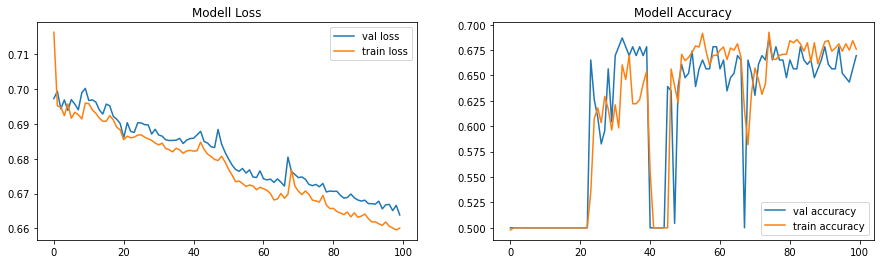

In [114]:
# plot model history
save_history(history_LSTM.history, current_time)

In [115]:
y_pred_LSTM = model_LSTM.predict(test_features_2d)

6/6 [==============================] - 1s 6ms/step


In [116]:
y_pred_LSTM = [pred_to_binary(x) for x in y_pred_LSTM]

In [117]:
print_performance_metrics(y_test,y_pred_LSTM)

Accuracy: 0.6359
ROC Area: 0.6359
Precision: 0.6487
Recall: 0.6359
F1 Score: 0.6279
Cohen Kappa Score: 0.2717
Matthews Corrcoef: 0.2843
		Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.49      0.57        92
           1       0.61      0.78      0.68        92

    accuracy                           0.64       184
   macro avg       0.65      0.64      0.63       184
weighted avg       0.65      0.64      0.63       184



In [122]:
# create a confusion matrix
cm_LSTM =  confusion_matrix(y_test,y_pred_LSTM)
cm_LSTM

array([[45, 47],
       [20, 72]])

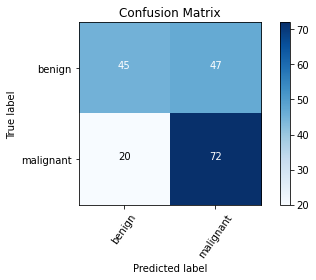

In [123]:
plot_confusion_matrix(cm_LSTM, cm_plot_label)

# Training Through Features

In [196]:
# create a training and validation dataset from the train df
train_df, val_df, test_df = create_splits(train, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])
print("rows in test_df", test_df.shape[0])

rows in train_df 966
rows in val_df 230
rows in test_df 184


In [197]:
train_features, train_labels = extract_features(train_df,use_model_features=True)
val_features, val_labels = extract_features(val_df,use_model_features=True)
test_features, test_labels = extract_features(test_df,use_model_features=True)

1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 77ms/step


1/1 [==============================] - 0s 76ms/step


1/1 [==============================] - 0s 89ms/step


1/1 [==============================] - 0s 90ms/step


1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 108ms/step


In [200]:
X_train, y_train = train_features, train_labels
X_val, y_val = val_features, val_labels
X_test, y_test = test_features, test_labels

## SVM

In [199]:
from sklearn.svm import SVC

# Create the SVM classifier with rbf kernel and set n_jobs to use all available cores
classifier_SVM = SVC(kernel='rbf', random_state=0)

# Fit the classifier to the training data
classifier_SVM.fit(X_train, y_train)

SVC(random_state=0)

In [201]:
train_acc_SVM = classifier_SVM.score(X_train, y_train)
val_acc_SVM = classifier_SVM.score(X_val, y_val)
test_acc_SVM = classifier_SVM.score(X_test, y_test)

In [202]:
print(train_acc_SVM)
print(val_acc_SVM)
print(test_acc_SVM)

0.9585921325051759
0.7956521739130434
0.75


In [203]:
y_pred_SVM = classifier_SVM.predict(X_test)

In [205]:
print_performance_metrics(y_test,y_pred_SVM)

Accuracy: 0.75
ROC Area: 0.75
Precision: 0.7624
Recall: 0.75
F1 Score: 0.747
Cohen Kappa Score: 0.5
Matthews Corrcoef: 0.5123
		Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72        92
           1       0.71      0.86      0.77        92

    accuracy                           0.75       184
   macro avg       0.76      0.75      0.75       184
weighted avg       0.76      0.75      0.75       184



In [206]:
# create a confusion matrix
cm_svm =  confusion_matrix(y_test,y_pred_SVM)
cm_svm

array([[59, 33],
       [13, 79]])

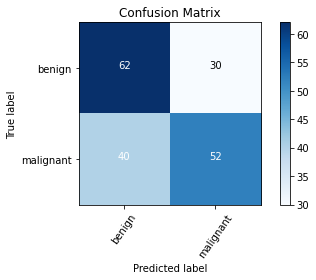

In [207]:
plot_confusion_matrix(cm_svm, cm_plot_label)

## KNN

In [208]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kNN = KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30)
classifier_kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree')

In [209]:
train_acc_KNN = classifier_kNN.score(X_train, y_train)
val_acc_KNN = classifier_kNN.score(X_val, y_val)
test_acc_KNN = classifier_kNN.score(X_test, y_test)

In [210]:
print(train_acc_SVM)
print(val_acc_SVM)
print(test_acc_SVM)

0.9585921325051759
0.7956521739130434
0.75


In [211]:
y_pred_kNN = classifier_SVM.predict(X_test)

In [212]:
print_performance_metrics(y_test,y_pred_kNN)

Accuracy: 0.75
ROC Area: 0.75
Precision: 0.7624
Recall: 0.75
F1 Score: 0.747
Cohen Kappa Score: 0.5
Matthews Corrcoef: 0.5123
		Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.64      0.72        92
           1       0.71      0.86      0.77        92

    accuracy                           0.75       184
   macro avg       0.76      0.75      0.75       184
weighted avg       0.76      0.75      0.75       184



In [213]:
# create a confusion matrix
cm_kNN =  confusion_matrix(y_test,y_pred_kNN)
cm_kNN

array([[59, 33],
       [13, 79]])

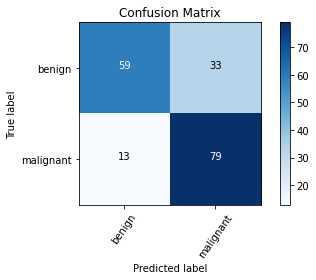

In [214]:
plot_confusion_matrix(cm_kNN, cm_plot_label)

## Logistic Regression

In [271]:
from sklearn.linear_model import LogisticRegression
classifier_LR = LogisticRegression(random_state=0)
classifier_LR.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
train_acc_LR = classifier_LR.score(X_train, y_train)
val_acc_LR = classifier_LR.score(X_val, y_val)
test_acc_LR = classifier_LR.score(X_test, y_test)

In [ ]:
print(train_acc_LR)
print(val_acc_LR)
print(test_acc_LR)

In [ ]:
y_pred_LR = classifier_LR.predict(X_test)

In [ ]:
print_performance_metrics(y_test,y_pred_LR)

In [ ]:
# create a confusion matrix
cm_LR =  confusion_matrix(y_test,y_pred_LR)
cm_LR

In [ ]:
plot_confusion_matrix(cm_LR, cm_plot_label)

### XGBoost (Decision Tree)

In [224]:
import xgboost as xgb
classifier_xgb = xgb.XGBClassifier(n_estimators = 300)
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [225]:
train_acc_xgb = classifier_xgb.score(X_train, y_train)
val_acc_xgb = classifier_xgb.score(X_val, y_val)
test_acc_xgb = classifier_xgb.score(X_test, y_test)

In [226]:
print(train_acc_xgb)
print(val_acc_xgb)
print(test_acc_xgb)

1.0
0.8043478260869565
0.7554347826086957


In [227]:
y_pred_xgb = classifier_xgb.predict(X_test)

In [228]:
print_performance_metrics(y_test,y_pred_xgb)

Accuracy: 0.7554
ROC Area: 0.7554
Precision: 0.7695
Recall: 0.7554
F1 Score: 0.7522
Cohen Kappa Score: 0.5109
Matthews Corrcoef: 0.5247
		Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.64      0.72        92
           1       0.71      0.87      0.78        92

    accuracy                           0.76       184
   macro avg       0.77      0.76      0.75       184
weighted avg       0.77      0.76      0.75       184



In [229]:
# create a confusion matrix
cm_xgb =  confusion_matrix(y_test,y_pred_xgb)
cm_xgb

array([[59, 33],
       [12, 80]])

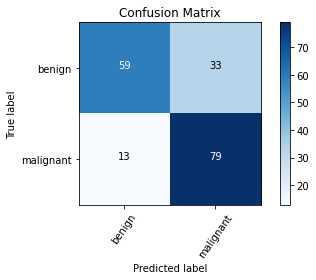

In [230]:
plot_confusion_matrix(cm_xgb, cm_plot_label)

### Random Forest

In [258]:
from sklearn.ensemble import RandomForestClassifier
classifier_RF = RandomForestClassifier(n_estimators = 800, criterion = 'entropy', random_state = 0)
classifier_RF.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=800, random_state=0)

In [260]:
train_acc_RF = classifier_RF.score(X_train, y_train)
val_acc_RF = classifier_RF.score(X_val, y_val)
test_acc_RF = classifier_RF.score(X_test, y_test)

In [261]:
print(train_acc_RF)
print(val_acc_RF)
print(test_acc_RF)

1.0
0.7782608695652173
0.7228260869565217


In [262]:
y_pred_rf = classifier_RF.predict(X_test)

In [264]:
print_performance_metrics(y_test,y_pred_rf)

Accuracy: 0.7228
ROC Area: 0.7228
Precision: 0.7274
Recall: 0.7228
F1 Score: 0.7214
Cohen Kappa Score: 0.4457
Matthews Corrcoef: 0.4502
		Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.65      0.70        92
           1       0.70      0.79      0.74        92

    accuracy                           0.72       184
   macro avg       0.73      0.72      0.72       184
weighted avg       0.73      0.72      0.72       184



In [266]:
cm_rf =  confusion_matrix(y_test,y_pred_rf)
cm_rf

array([[60, 32],
       [19, 73]])

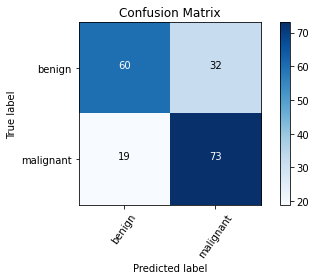

In [267]:
plot_confusion_matrix(cm_rf, cm_plot_label)

### CNN

In [232]:
EPOCHS = 30

In [233]:
model_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(7, 7, 512)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(1, 1)), # reduce only depth dimension
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


LEARNING_RATE = 1e-4
OPTIMIZER = RMSprop(lr=LEARNING_RATE,decay=1e-2)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model_CNN.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

print("fit model on gpu")
history_CNN = model_CNN.fit(
    np.reshape(train_features,(train_features.shape[0],7,7,512)), train_labels, 
    epochs=EPOCHS, 
    verbose=VERBOSE_LEVEL, 
    validation_data=( np.reshape(val_features,(val_features.shape[0],7,7,512)),val_labels)
)

fit model on gpu
Epoch 1/30
31/31 [==============================] - 1s 23ms/step - loss: 0.6710 - accuracy: 0.5776 - auc: 0.6233 - val_loss: 0.6148 - val_accuracy: 0.6870 - val_auc: 0.7691
Epoch 2/30
31/31 [==============================] - 0s 16ms/step - loss: 0.5618 - accuracy: 0.7816 - auc: 0.8584 - val_loss: 0.5814 - val_accuracy: 0.7348 - val_auc: 0.8110
Epoch 3/30
31/31 [==============================] - 0s 15ms/step - loss: 0.4883 - accuracy: 0.8292 - auc: 0.9047 - val_loss: 0.5462 - val_accuracy: 0.7261 - val_auc: 0.8220
Epoch 4/30
31/31 [==============================] - 0s 16ms/step - loss: 0.4267 - accuracy: 0.8810 - auc: 0.9365 - val_loss: 0.5320 - val_accuracy: 0.7478 - val_auc: 0.8350
Epoch 5/30
31/31 [==============================] - 0s 16ms/step - loss: 0.3779 - accuracy: 0.8799 - auc: 0.9531 - val_loss: 0.4980 - val_accuracy: 0.7609 - val_auc: 0.8454
Epoch 6/30
31/31 [==============================] - 1s 16ms/step - loss: 0.3382 - accuracy: 0.9037 - auc: 0.9644 - val

In [239]:
y_pred_CNN = model_CNN.predict(np.reshape(X_test, (X_test.shape[0], 7, 7, 512)))

6/6 [==============================] - 0s 3ms/step


In [240]:
y_pred_CNN = [pred_to_binary(x) for x in y_pred_CNN]

In [243]:
print_performance_metrics(y_test,y_pred_CNN)

Accuracy: 0.7337
ROC Area: 0.7337
Precision: 0.7371
Recall: 0.7337
F1 Score: 0.7327
Cohen Kappa Score: 0.4674
Matthews Corrcoef: 0.4708
		Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.67      0.72        92
           1       0.71      0.79      0.75        92

    accuracy                           0.73       184
   macro avg       0.74      0.73      0.73       184
weighted avg       0.74      0.73      0.73       184



In [244]:
# create a confusion matrix
cm_cnn =  confusion_matrix(y_test,y_pred_CNN)
cm_cnn

array([[62, 30],
       [19, 73]])

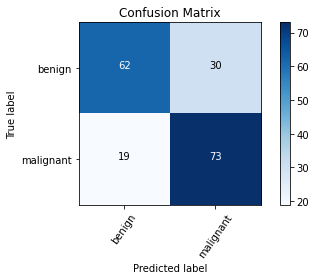

In [245]:
plot_confusion_matrix(cm_cnn, cm_plot_label)

## RNN

In [246]:
#For LSTMs

train_features_2d = np.zeros((train_len,last_layer_shape[1],last_layer_shape[2]*last_layer_shape[3]))
for i in range(len(train_labels)):
    train_features_2d[i] = train_features[i].reshape(last_layer_shape[1],
                                                     last_layer_shape[2]*last_layer_shape[3])
    
val_features_2d = np.zeros((val_len,last_layer_shape[1],last_layer_shape[2]*last_layer_shape[3]))
for i in range(len(val_labels)):
    val_features_2d[i] = val_features[i].reshape(last_layer_shape[1],
                                                     last_layer_shape[2]*last_layer_shape[3])
    
test_features_2d = np.zeros((test_len,last_layer_shape[1],last_layer_shape[2]*last_layer_shape[3]))
for i in range(len(test_labels)):
    test_features_2d[i] = test_features[i].reshape(last_layer_shape[1],
                                                     last_layer_shape[2]*last_layer_shape[3])

In [247]:
model_LSTM = tf.keras.models.Sequential([
    tf.keras.Input(shape=(last_layer_shape[1], last_layer_shape[2]*last_layer_shape[3])),
    tf.keras.layers.LSTM(100, return_sequences=True),
    #tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

LEARNING_RATE = 1e-4
OPTIMIZER = Adam(lr=LEARNING_RATE,decay=1e-2)
LOSS = 'binary_crossentropy'
METRICS = [
    'accuracy', 
    'AUC'
] 

model_LSTM.compile(
    loss=LOSS,
    metrics=METRICS,
    optimizer=OPTIMIZER,
)

print("fit model on gpu")
history_LSTM = model_LSTM.fit(
    train_features_2d, train_labels, 
    epochs=EPOCHS, 
    verbose=VERBOSE_LEVEL,
    validation_data=(val_features_2d,val_labels)
)

fit model on gpu
Epoch 1/30
31/31 [==============================] - 15s 61ms/step - loss: 0.6675 - accuracy: 0.5849 - auc: 0.6370 - val_loss: 0.6078 - val_accuracy: 0.7174 - val_auc: 0.7883
Epoch 2/30
31/31 [==============================] - 1s 28ms/step - loss: 0.5397 - accuracy: 0.8354 - auc: 0.9289 - val_loss: 0.5660 - val_accuracy: 0.7522 - val_auc: 0.8161
Epoch 3/30
31/31 [==============================] - 1s 29ms/step - loss: 0.4579 - accuracy: 0.9079 - auc: 0.9695 - val_loss: 0.5359 - val_accuracy: 0.7522 - val_auc: 0.8298
Epoch 4/30
31/31 [==============================] - 1s 29ms/step - loss: 0.3893 - accuracy: 0.9441 - auc: 0.9863 - val_loss: 0.5147 - val_accuracy: 0.7565 - val_auc: 0.8369
Epoch 5/30
31/31 [==============================] - 1s 29ms/step - loss: 0.3338 - accuracy: 0.9679 - auc: 0.9936 - val_loss: 0.4972 - val_accuracy: 0.7696 - val_auc: 0.8461
Epoch 6/30
31/31 [==============================] - 1s 29ms/step - loss: 0.2857 - accuracy: 0.9752 - auc: 0.9968 - va

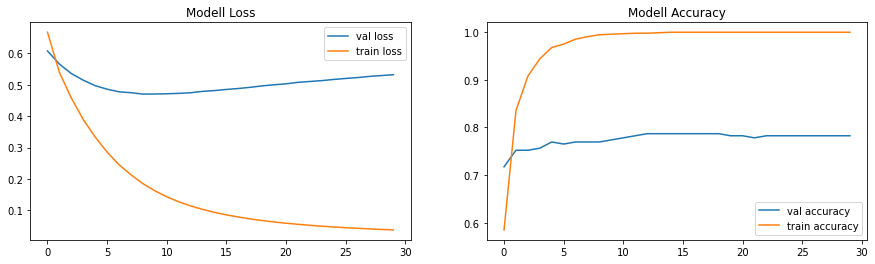

In [248]:
# plot model history
save_history(history_LSTM.history, current_time)

In [249]:
y_pred_LSTM = model_LSTM.predict(test_features_2d)

6/6 [==============================] - 1s 5ms/step


In [255]:
y_pred_LSTM = [pred_to_binary(x) for x in y_pred_LSTM]

In [256]:
print_performance_metrics(y_test,y_pred_LSTM)

Accuracy: 0.7283
ROC Area: 0.7283
Precision: 0.73
Recall: 0.7283
F1 Score: 0.7277
Cohen Kappa Score: 0.4565
Matthews Corrcoef: 0.4583
		Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.68      0.72        92
           1       0.71      0.77      0.74        92

    accuracy                           0.73       184
   macro avg       0.73      0.73      0.73       184
weighted avg       0.73      0.73      0.73       184



In [252]:
# create a confusion matrix
cm_LSTM =  confusion_matrix(y_test,y_pred_LSTM)
cm_LSTM

array([[63, 29],
       [21, 71]])

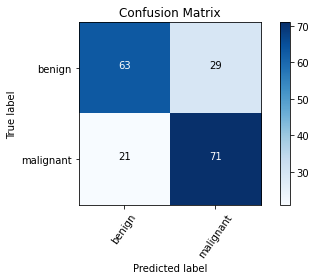

In [253]:
plot_confusion_matrix(cm_LSTM, cm_plot_label)

/home/precision/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(0.0, 1.0)

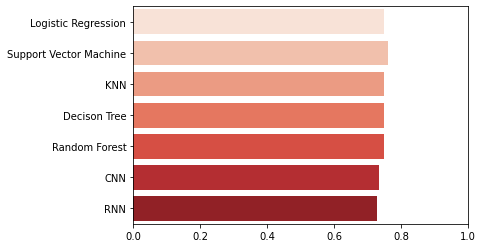

In [3]:
x_l = ['Logistic Regression', 'Support Vector Machine', 'KNN', 'Decison Tree', 'Random Forest','CNN', 'RNN']
y_l = [0.75, 0.76, 0.75, 0.75, 0.75, 0.7337, 0.7283]

sns.barplot(y_l, x_l, palette="Reds")
plt.xlim([0, 1])

# Training Through Details 

In [125]:
train_df = df

In [126]:
train_df = train_df.dropna(axis=0, how = 'any')

In [127]:
# 1 means 50 / 50 => equal amount of positive and negative cases in Training
# 4 = 20%; 8 = ~11%; 12 = ~8%
balance = 1
p_inds = train_df[train_df.target == 1].index.tolist()
np_inds = train_df[train_df.target == 0].index.tolist()

np_sample = random.sample(np_inds, balance * len(p_inds))
train_df = train_df.loc[p_inds + np_sample]
print("Samples in train", df['target'].sum()/len(train_df))
print("Remaining rows in train set", len(train_df))

Samples in train 0.5
Remaining rows in train set 1150


## Encoding

Codifying categorical variables and normalizing numeric features

**Sectioning into categorical and numerical features**

In [128]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150 entries, 91 to 20712
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   image_name              1150 non-null   object
 1   patient_id              1150 non-null   object
 2   age_approx              1150 non-null   int64 
 3   target                  1150 non-null   int64 
 4   tfrecord                1150 non-null   int64 
 5   width                   1150 non-null   int64 
 6   height                  1150 non-null   int64 
 7   image_path              1150 non-null   object
 8   sex_female              1150 non-null   int64 
 9   sex_male                1150 non-null   int64 
 10  anatom_head/neck        1150 non-null   int64 
 11  anatom_lower extremity  1150 non-null   int64 
 12  anatom_oral/genital     1150 non-null   int64 
 13  anatom_palms/soles      1150 non-null   int64 
 14  anatom_torso            1150 non-null   int64 
 15  an

In [129]:
if 'benign_malignant' in train_df.columns : train_df.drop(['benign_malignant'], axis=1, inplace=True)
if 'tfrecord' in train_df.columns : train_df.drop(['tfrecord'], axis=1, inplace=True)
if 'width' in train_df.columns : train_df.drop(['width'], axis=1, inplace=True)
if 'height' in train_df.columns : train_df.drop(['height'], axis=1, inplace=True)
if 'patient_id' in train_df.columns : train_df.drop(['patient_id'], axis=1, inplace=True)
if 'path_jpeg' in train_df.columns : train_df.drop(['path_jpeg'], axis=1, inplace=True)
if 'image_path' in train_df.columns : train_df.drop(['image_path'], axis=1, inplace=True)

In [130]:
train_df.head()

image_name  age_approx  target  sex_female  sex_male  anatom_head/neck  \
91   ISIC_0149568          55       1           1         0                 0   
235  ISIC_0188432          50       1           1         0                 0   
314  ISIC_0207268          55       1           0         1                 0   
399  ISIC_0232101          65       1           0         1                 0   
459  ISIC_0247330          65       1           1         0                 0   

     anatom_lower extremity  anatom_oral/genital  anatom_palms/soles  \
91                        0                    0                   0   
235                       0                    0                   0   
314                       0                    0                   0   
399                       0                    0                   0   
459                       1                    0                   0   

     anatom_torso  anatom_upper extremity  
91              0                       1  
235             0                       1  
314             1                       0  
399             1                       0  
459             0                       0

<AxesSubplot:>

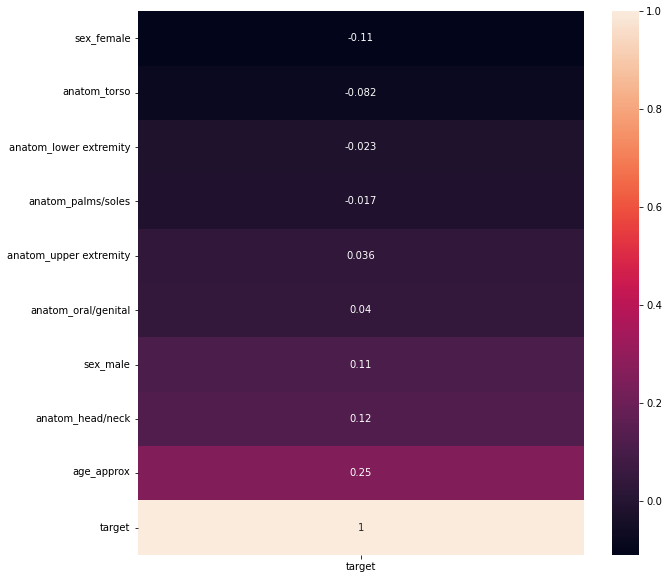

In [131]:
plt.figure(figsize = (10,10))
sns.heatmap(train_df.corr()[['target']].sort_values('target').tail(16), annot = True)

<AxesSubplot:xlabel='anatom_lower extremity', ylabel='target'>

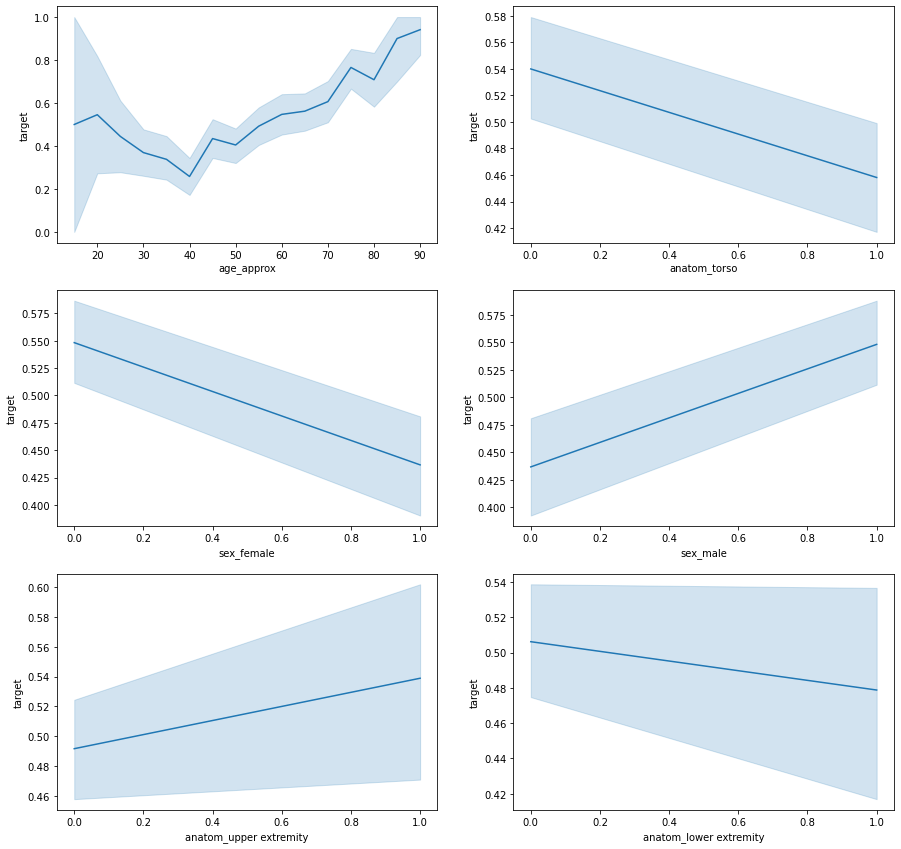

In [132]:
plt.figure(figsize=(15,20))

plt.subplot(4,2,1)
sns.lineplot(train_df['age_approx'], train_df['target'])
plt.subplot(4,2,2)
sns.lineplot(train_df['anatom_torso'], train_df['target'])
plt.subplot(4,2,3)
sns.lineplot(train_df['sex_female'], train_df['target'])
plt.subplot(4,2,4)
sns.lineplot(train_df['sex_male'], train_df['target'])
plt.subplot(4,2,5)
sns.lineplot(train_df['anatom_upper extremity'], train_df['target'])
plt.subplot(4,2,6)
sns.lineplot(train_df['anatom_lower extremity'], train_df['target'])

  # 3.  Training and Testing the Model

I will Go about training the models through 2 ways ones through only the csv files and details in it and other only throught the images

## Training Through Details

In [133]:
# create a training and validation dataset from the train df
train_df, val_df, test_df = create_splits(train_df, 0.2, 'target')

print("rows in train_df", train_df.shape[0])
print("rows in val_df", val_df.shape[0])
print("rows in test_df", test_df.shape[0])

rows in train_df 966
rows in val_df 230
rows in test_df 184


In [134]:
X_train = train_df[['sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity','age_approx']]
y_train = train_df['target']
X_val = val_df[['sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity','age_approx']]
y_val = val_df['target']
X_test = test_df[['sex_male', 'anatom_head/neck',
       'anatom_lower extremity', 'anatom_oral/genital', 'anatom_palms/soles',
       'anatom_torso', 'anatom_upper extremity','age_approx']]
y_test = test_df['target']

### Logistic Regression

In [156]:
from sklearn.linear_model import LogisticRegression

classifier_lr = LogisticRegression()
classifier_lr.fit(X_train,y_train)

LogisticRegression()

In [137]:
train_acc_LR = classifier_lr.score(X_train, y_train)
val_acc_LR = classifier_lr.score(X_val, y_val)
test_acc_LR = classifier_lr.score(X_test, y_test)

In [138]:
print(train_acc_LR)
print(val_acc_LR)
print(test_acc_LR)

0.6262939958592133
0.6086956521739131
0.5978260869565217


In [139]:
y_pred_lr = classifier_lr.predict(X_test)

In [141]:
print_performance_metrics(y_test,y_pred_lr)

Accuracy: 0.5978
ROC Area: 0.5978
Precision: 0.598
Recall: 0.5978
F1 Score: 0.5976
Cohen Kappa Score: 0.1957
Matthews Corrcoef: 0.1958
		Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.58      0.59        92
           1       0.59      0.62      0.61        92

    accuracy                           0.60       184
   macro avg       0.60      0.60      0.60       184
weighted avg       0.60      0.60      0.60       184



In [140]:
# create a confusion matrix
cm_lr =  confusion_matrix(y_test,y_pred_lr)
cm_lr

array([[53, 39],
       [35, 57]])

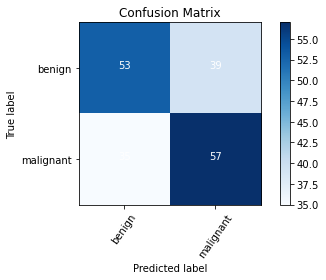

In [142]:
plot_confusion_matrix(cm_lr, cm_plot_label)

## Support Vector Machine

In [143]:
from sklearn import svm

classifier_svm = svm.SVC()
classifier_svm.fit(X_train,y_train)

SVC()

In [144]:
train_acc_SVM = classifier_svm.score(X_train, y_train)
val_acc_SVM = classifier_svm.score(X_val, y_val)
test_acc_SVM = classifier_svm.score(X_test, y_test)

In [146]:
print(train_acc_SVM)
print(val_acc_SVM)
print(test_acc_SVM)

0.6138716356107661
0.6304347826086957
0.6195652173913043


In [145]:
y_pred_svm = classifier_svm.predict(X_test)

In [147]:
print_performance_metrics(y_test,y_pred_svm)

Accuracy: 0.6196
ROC Area: 0.6196
Precision: 0.621
Recall: 0.6196
F1 Score: 0.6184
Cohen Kappa Score: 0.2391
Matthews Corrcoef: 0.2406
		Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.67      0.64        92
           1       0.63      0.57      0.60        92

    accuracy                           0.62       184
   macro avg       0.62      0.62      0.62       184
weighted avg       0.62      0.62      0.62       184



In [148]:
# create a confusion matrix
cm_svm =  confusion_matrix(y_test,y_pred_svm)
cm_svm

array([[62, 30],
       [40, 52]])

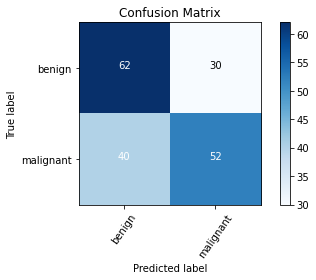

In [149]:
plot_confusion_matrix(cm_svm, cm_plot_label)

## KNN

In [184]:
from sklearn.neighbors import KNeighborsClassifier
classifier_kNN = KNeighborsClassifier(n_neighbors = 5, algorithm='ball_tree', leaf_size=30)
classifier_kNN.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree')

In [185]:
train_acc_kNN = classifier_kNN.score(X_train, y_train)
val_acc_kNN = classifier_kNN.score(X_val, y_val)
test_acc_kNN = classifier_kNN.score(X_test, y_test)

In [186]:
print(train_acc_kNN)
print(val_acc_kNN)
print(test_acc_kNN)

0.6314699792960663
0.6
0.5760869565217391


In [189]:
y_pred_kNN = classifier_kNN.predict(X_test)

In [190]:
print_performance_metrics(y_test,y_pred_dt)

Accuracy: 0.6304
ROC Area: 0.6304
Precision: 0.6345
Recall: 0.6304
F1 Score: 0.6276
Cohen Kappa Score: 0.2609
Matthews Corrcoef: 0.2649
		Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.72      0.66        92
           1       0.66      0.54      0.60        92

    accuracy                           0.63       184
   macro avg       0.63      0.63      0.63       184
weighted avg       0.63      0.63      0.63       184



In [191]:
# create a confusion matrix
cm_dt =  confusion_matrix(y_test,y_pred_kNN)
cm_dt

array([[45, 47],
       [31, 61]])

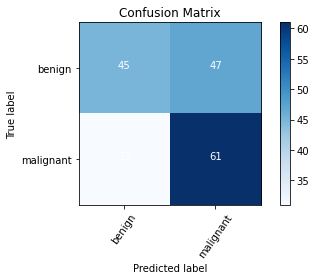

In [192]:
plot_confusion_matrix(cm_dt, cm_plot_label)

## Random Forest

In [169]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier()
classifier_rf.fit(X_train,y_train)

RandomForestClassifier()

In [170]:
train_acc_rf = classifier_rf.score(X_train, y_train)
val_acc_rf = classifier_rf.score(X_val, y_val)
test_acc_rf = classifier_rf.score(X_test, y_test)

In [171]:
print(train_acc_rf)
print(val_acc_rf)
print(test_acc_rf)

0.6739130434782609
0.6608695652173913
0.6304347826086957


In [172]:
y_pred_rf = classifier_rf.predict(X_test)

In [173]:
print_performance_metrics(y_test,y_pred_rf)

Accuracy: 0.6304
ROC Area: 0.6304
Precision: 0.6307
Recall: 0.6304
F1 Score: 0.6303
Cohen Kappa Score: 0.2609
Matthews Corrcoef: 0.2611
		Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.65      0.64        92
           1       0.64      0.61      0.62        92

    accuracy                           0.63       184
   macro avg       0.63      0.63      0.63       184
weighted avg       0.63      0.63      0.63       184



In [174]:
# create a confusion matrix
cm_rf =  confusion_matrix(y_test,y_pred_rf)
cm_rf

array([[60, 32],
       [36, 56]])

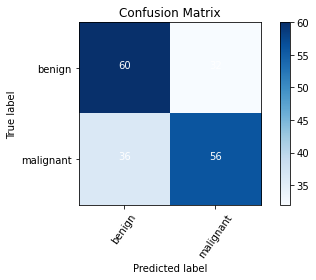

In [175]:
plot_confusion_matrix(cm_rf, cm_plot_label)

## XGBoost

In [176]:
import xgboost as xgb

classifier_xgb = xgb.XGBClassifier(n_estimators = 300)
classifier_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [177]:
train_acc_xgb = classifier_xgb.score(X_train, y_train)
val_acc_xgb = classifier_xgb.score(X_val, y_val)
test_acc_xgb = classifier_xgb.score(X_test, y_test)

In [178]:
print(train_acc_xgb)
print(val_acc_xgb)
print(test_acc_xgb)

0.6728778467908902
0.6652173913043479
0.6413043478260869


In [179]:
y_pred_xgb = classifier_xgb.predict(X_test)

In [180]:
print_performance_metrics(y_test,y_pred_xgb)

Accuracy: 0.6413
ROC Area: 0.6413
Precision: 0.6419
Recall: 0.6413
F1 Score: 0.6409
Cohen Kappa Score: 0.2826
Matthews Corrcoef: 0.2832
		Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.67      0.65        92
           1       0.65      0.61      0.63        92

    accuracy                           0.64       184
   macro avg       0.64      0.64      0.64       184
weighted avg       0.64      0.64      0.64       184



In [181]:
# create a confusion matrix
cm_xgb =  confusion_matrix(y_test,y_pred_xgb)
cm_xgb

array([[62, 30],
       [36, 56]])

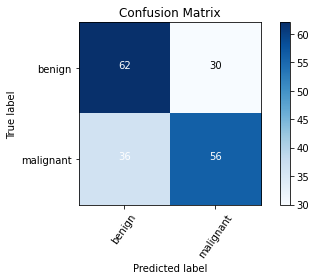

In [182]:
plot_confusion_matrix(cm_xgb, cm_plot_label)

(0.0, 1.0)

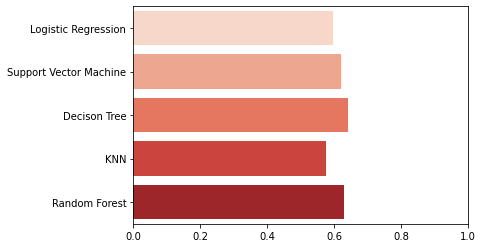

In [193]:
x_l = ['Logistic Regression', 'Support Vector Machine', 'Decison Tree','KNN', 'Random Forest']
y_l = [test_acc_LR, test_acc_SVM, test_acc_xgb, test_acc_kNN, test_acc_rf]

sns.barplot(y_l, x_l, palette="Reds")
plt.xlim([0, 1])